# Import

In [1]:
# Packages
from pandas import read_csv, DataFrame
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from numpy import array, mean, append
from matplotlib.pyplot import savefig, xlim, ylim
from os import makedirs
from IPython.display import display

In [2]:
# Helpers
# https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
            
    return pvalues

# https://towardsdatascience.com/cronbachs-alpha-theory-and-application-in-python-d2915dd63586
def cronbach_alpha(df):
    df_corr = df.corr()
    N = df.shape[1]
    rs = array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = append(sum_, rs)
        
    mean_r = mean(rs)
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

# Setup

In [3]:
# Load data and setup output dir
data = read_csv("data/anon.csv", sep="\t")
display(data.head())

makedirs("output", exist_ok=True)

,user_sha1,total_events,total_breaks,total_submit,total_snapshot,total_view,total_manipulate,n_puzzle,n_puz_no_basic,p_puz_no_basic,...,item25,item26,item27,item28,item29,item30,sri,mr,so,sv
0,5787ea1cb8ec38d1fe05510b4472ed73ab995578,768,25,25,0,31,170,9,2,0.095238,...,0.0,1.0,1.0,0.0,0.0,0.0,10.0,2.0,6.0,2.0
1,e76056103a0f740752859aec222102e77af132a4,25,1,4,0,0,6,2,0,0.000000,...,0.0,1.0,1.0,1.0,1.0,1.0,24.0,9.0,9.0,6.0
2,61b6b2ed7c2d28f51122a5dcea07d30de9a8dfa7,1874,47,67,158,416,598,30,21,1.000000,...,0.0,1.0,0.0,1.0,1.0,1.0,27.0,9.0,10.0,8.0
3,ace95c14c44d1cce2494ba11d81c297259d09c9a,1660,55,37,0,96,634,26,17,0.809524,...,0.0,1.0,0.0,0.0,1.0,1.0,16.0,3.0,8.0,5.0
4,2c510471bfc0d07085c7988ba837397b849f12d9,567,17,16,13,50,236,9,1,0.047619,...,0.0,1.0,0.0,0.0,1.0,0.0,17.0,4.0,10.0,3.0


In [4]:
# Clean data
data["q15_gpa"] = data["q15"].map({
    "A": 4,
    "B": 3,
    "C": 2,
    "D": 1,
    "F": 0
})

data["gender_number"] = data["gender"].map({
    "Male": 0,
    "Female": 1
})

display(data.head())

,user_sha1,total_events,total_breaks,total_submit,total_snapshot,total_view,total_manipulate,n_puzzle,n_puz_no_basic,p_puz_no_basic,...,item27,item28,item29,item30,sri,mr,so,sv,q15_gpa,gender_number
0,5787ea1cb8ec38d1fe05510b4472ed73ab995578,768,25,25,0,31,170,9,2,0.095238,...,1.0,0.0,0.0,0.0,10.0,2.0,6.0,2.0,NaN,1.0
1,e76056103a0f740752859aec222102e77af132a4,25,1,4,0,0,6,2,0,0.000000,...,1.0,1.0,1.0,1.0,24.0,9.0,9.0,6.0,3.0,1.0
2,61b6b2ed7c2d28f51122a5dcea07d30de9a8dfa7,1874,47,67,158,416,598,30,21,1.000000,...,0.0,1.0,1.0,1.0,27.0,9.0,10.0,8.0,4.0,0.0
3,ace95c14c44d1cce2494ba11d81c297259d09c9a,1660,55,37,0,96,634,26,17,0.809524,...,0.0,0.0,1.0,1.0,16.0,3.0,8.0,5.0,4.0,1.0
4,2c510471bfc0d07085c7988ba837397b849f12d9,567,17,16,13,50,236,9,1,0.047619,...,0.0,0.0,1.0,0.0,17.0,4.0,10.0,3.0,NaN,0.0


In [5]:
# Composite values
agree_map = {
    "Strongly agree": 2,
    "Somewhat agree": 1,
    "Neither agree nor disagree": 0,
    "Somewhate disagree": -1,
    "Strongly disagree": -2,
}

data["enjoyment"] = data["q1_1"].map(agree_map).fillna(0) + data["q1_2"].map(agree_map).fillna(0) - data["q1_3"].map(agree_map).fillna(0) + data["q1_4"].map(agree_map).fillna(0) + data["q1_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["math_efficacy"] = data["q13_1"].map(agree_map).fillna(0) + data["q13_2"].map(agree_map).fillna(0) + data["q13_3"].map(agree_map).fillna(0) + data["q13_4"].map(agree_map).fillna(0) + data["q13_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)
data["math_anxiety"] = data["q14_1"].map(agree_map).fillna(0) + data["q14_2"].map(agree_map).fillna(0) + data["q14_3"].map(agree_map).fillna(0) + data["q14_4"].map(agree_map).fillna(0) + data["q14_5"].map(agree_map).fillna(0) + data["q1_6"].map(agree_map).fillna(0)

display(data.head())

,user_sha1,total_events,total_breaks,total_submit,total_snapshot,total_view,total_manipulate,n_puzzle,n_puz_no_basic,p_puz_no_basic,...,item30,sri,mr,so,sv,q15_gpa,gender_number,enjoyment,math_efficacy,math_anxiety
0,5787ea1cb8ec38d1fe05510b4472ed73ab995578,768,25,25,0,31,170,9,2,0.095238,...,0.0,10.0,2.0,6.0,2.0,NaN,1.0,0.0,0.0,0.0
1,e76056103a0f740752859aec222102e77af132a4,25,1,4,0,0,6,2,0,0.000000,...,1.0,24.0,9.0,9.0,6.0,3.0,1.0,3.0,0.0,0.0
2,61b6b2ed7c2d28f51122a5dcea07d30de9a8dfa7,1874,47,67,158,416,598,30,21,1.000000,...,1.0,27.0,9.0,10.0,8.0,4.0,0.0,5.0,1.0,1.0
3,ace95c14c44d1cce2494ba11d81c297259d09c9a,1660,55,37,0,96,634,26,17,0.809524,...,1.0,16.0,3.0,8.0,5.0,4.0,1.0,-4.0,1.0,1.0
4,2c510471bfc0d07085c7988ba837397b849f12d9,567,17,16,13,50,236,9,1,0.047619,...,0.0,17.0,4.0,10.0,3.0,NaN,0.0,0.0,0.0,0.0


In [6]:
# What columns do we care about and what dependent variable col are we trying to predict?
cols = [
    "total_events",
    "total_breaks",
    "total_submit",
    "total_snapshot",
    "total_view",
    "total_manipulate",
    "n_puzzle",
    "n_puz_no_basic",
    "p_puz_no_basic",
    "n_complete",
    "n_tutorial",
    "n_interm",
    # "n_adv", # missing over 30 values
    "total_active",
    "complete_active",
    "incomplete_active",
    "tutorial_atime_comp",
    # "int_atime_comp", # missing over 30 values
    # "adv_atime_comp", # missing over 30 values
    # "tutorial_atime_incomp", # missing over 30 values
    # "int_atime_incomp", # missing over 30 values
    # "adv_atime_incomp", # missing over 30 values
    "cumu_a_time",
    "persistence_score",
    "non_per",
    "productive",
    "unproductive",
    "rapid",
    "no_beh",
    "avg_revisit",
    "n_attempt",
    "n_failed_att",
    "revisits",
    "diff_event1",
    "diff_event2",
    # "diff_event3", # missing over 30 values
    "different_event",
    "sbst",
    "gender_number",
    "enjoyment",
    "sri"
]

dep_col = "sri"

# Descriptive Stats

In [7]:
# Display how many missing values are in each column
for col in cols:
  print(f"Variable: {col:20} Missing Values: {data[col].isna().sum()}")

Variable: total_events         Missing Values: 0
Variable: total_breaks         Missing Values: 0
Variable: total_submit         Missing Values: 0
Variable: total_snapshot       Missing Values: 0
Variable: total_view           Missing Values: 0
Variable: total_manipulate     Missing Values: 0
Variable: n_puzzle             Missing Values: 0
Variable: n_puz_no_basic       Missing Values: 0
Variable: p_puz_no_basic       Missing Values: 0
Variable: n_complete           Missing Values: 0
Variable: n_tutorial           Missing Values: 0
Variable: n_interm             Missing Values: 9
Variable: total_active         Missing Values: 0
Variable: complete_active      Missing Values: 2
Variable: incomplete_active    Missing Values: 3
Variable: tutorial_atime_comp  Missing Values: 2
Variable: cumu_a_time          Missing Values: 0
Variable: persistence_score    Missing Values: 0
Variable: non_per              Missing Values: 0
Variable: productive           Missing Values: 0
Variable: unproducti

In [8]:
# Correlation analysis
corr = data[cols].corr()
corr.to_csv("output/corr.csv", sep="\t")
display(corr)

,total_events,total_breaks,total_submit,total_snapshot,total_view,total_manipulate,n_puzzle,n_puz_no_basic,p_puz_no_basic,n_complete,...,n_attempt,n_failed_att,revisits,diff_event1,diff_event2,different_event,sbst,gender_number,enjoyment,sri
total_events,1.000000,0.645940,0.831245,0.878537,0.873332,0.969912,0.729461,0.726490,0.726490,0.649441,...,0.897161,0.861734,0.822404,0.597588,0.635660,0.853643,0.121307,0.132064,0.316903,0.080549
total_breaks,0.645940,1.000000,0.810802,0.430055,0.321672,0.752608,0.635879,0.622537,0.622537,0.480924,...,0.562676,0.523672,0.435440,0.501087,0.414560,0.643709,-0.016558,0.121806,0.159102,0.022078
total_submit,0.831245,0.810802,1.000000,0.549738,0.566189,0.878835,0.738982,0.730438,0.730438,0.552429,...,0.787525,0.761528,0.674068,0.595123,0.603175,0.789717,-0.011722,0.125847,0.205949,-0.112170
total_snapshot,0.878537,0.430055,0.549738,1.000000,0.878556,0.802186,0.528741,0.534731,0.534731,0.588544,...,0.744625,0.703888,0.719344,0.441536,0.509094,0.692253,0.203829,0.178330,0.387691,0.229070
total_view,0.873332,0.321672,0.566189,0.878556,1.000000,0.754409,0.537787,0.526580,0.526580,0.590044,...,0.741333,0.700245,0.710226,0.508646,0.524521,0.695472,0.124007,0.152849,0.295414,0.111049
total_manipulate,0.969912,0.752608,0.878835,0.802186,0.754409,1.000000,0.763683,0.762474,0.762474,0.640513,...,0.894411,0.858777,0.803405,0.592591,0.616873,0.854707,0.136284,0.101037,0.305830,0.099319
n_puzzle,0.729461,0.635879,0.738982,0.528741,0.537787,0.763683,1.000000,0.979048,0.979048,0.842271,...,0.750547,0.623196,0.496214,0.654089,0.829138,0.956391,0.302955,0.004649,0.300282,0.129835
n_puz_no_basic,0.726490,0.622537,0.730438,0.534731,0.526580,0.762474,0.979048,1.000000,1.000000,0.809996,...,0.756444,0.640030,0.513893,0.502394,0.823465,0.932320,0.294247,-0.056788,0.356640,0.175193
p_puz_no_basic,0.726490,0.622537,0.730438,0.534731,0.526580,0.762474,0.979048,1.000000,1.000000,0.809996,...,0.756444,0.640030,0.513893,0.502394,0.823465,0.932320,0.294247,-0.056788,0.356640,0.175193
n_complete,0.649441,0.480924,0.552429,0.588544,0.590044,0.640513,0.842271,0.809996,0.809996,1.000000,...,0.648847,0.442110,0.442387,0.568694,0.833165,0.892616,0.558489,-0.120111,0.359677,0.323951


In [9]:
# p values
pvals = DataFrame(calculate_pvalues(data[cols]))
pvals.to_csv("output/pvals.csv", sep="\t")
display(pvals)

,total_events,total_breaks,total_submit,total_snapshot,total_view,total_manipulate,n_puzzle,n_puz_no_basic,p_puz_no_basic,n_complete,...,n_attempt,n_failed_att,revisits,diff_event1,diff_event2,different_event,sbst,gender_number,enjoyment,sri
total_events,0.0,0.0004,0.0,0.0,0.0,0.0,0.0001,0.0001,0.0001,0.0005,...,0.0,0.0,0.0,0.0005,0.0002,0.0,0.9983,0.5284,0.0351,0.6857
total_breaks,0.0004,0.0,0.0,0.0272,0.212,0.0,0.0005,0.0005,0.0005,0.0387,...,0.0044,0.0068,0.0286,0.0142,0.0249,0.0004,0.4538,0.4505,0.0938,0.896
total_submit,0.0,0.0,0.0,0.004,0.0051,0.0,0.0,0.0,0.0,0.0139,...,0.0,0.0,0.0001,0.001,0.0006,0.0,0.382,0.5777,0.0817,0.3995
total_snapshot,0.0,0.0272,0.004,0.0,0.0,0.0,0.0049,0.005,0.005,0.0002,...,0.0,0.0,0.0,0.0081,0.0031,0.0,0.3879,0.4057,0.0133,0.1265
total_view,0.0,0.212,0.0051,0.0,0.0,0.0,0.0143,0.0172,0.0172,0.0014,...,0.0,0.0001,0.0,0.0028,0.0035,0.0,0.8646,0.4468,0.0718,0.484
total_manipulate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0009,...,0.0,0.0,0.0,0.0008,0.0004,0.0,0.9437,0.6458,0.0495,0.6442
n_puzzle,0.0001,0.0005,0.0,0.0049,0.0143,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0005,0.0066,0.0097,0.0,0.0,0.4006,0.9174,0.0286,0.2068
n_puz_no_basic,0.0001,0.0005,0.0,0.005,0.0172,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0004,0.0056,0.0493,0.0,0.0,0.3192,0.7456,0.0245,0.1612
p_puz_no_basic,0.0001,0.0005,0.0,0.005,0.0172,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0004,0.0056,0.0493,0.0,0.0,0.3192,0.7456,0.0245,0.1612
n_complete,0.0005,0.0387,0.0139,0.0002,0.0014,0.0009,0.0,0.0,0.0,0.0,...,0.0006,0.0337,0.0177,0.0648,0.0,0.0,0.002,0.3364,0.0043,0.0009


In [10]:
# Cronbach's Alpha
alpha = cronbach_alpha(data[["sri", "sbst"]])
print(f"Cronbach's Alpha for SRI and SBST: {alpha}")

Cronbach's Alpha for SRI and SBST: 0.757301787558002


# Random Forest

In [11]:
# Drop empty data and split into labels and features
good_data = data[data["sri"] > 0][cols].dropna()
labels = array(good_data[dep_col])
features = array(good_data.drop(dep_col, axis=1))

In [12]:
# Split into train and test
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25, random_state=42)
print("Training Features Shape:", train_features.shape)
print("Training Labels Shape:", train_labels.shape)
print("Testing Features Shape:", test_features.shape)
print("Testing Labels Shape:", test_labels.shape)

Training Features Shape: (22, 33)
Training Labels Shape: (22,)
Testing Features Shape: (8, 33)
Testing Labels Shape: (8,)


In [13]:
# Fit model
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [14]:
# Check model error
predictions = rf.predict(test_features)
errors = abs(predictions - test_labels)
print("Mean Absolute Error:", round(mean(errors), 2), "degrees.")

Mean Absolute Error: 3.68 degrees.


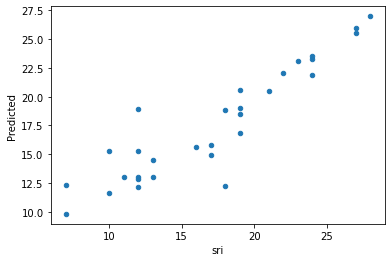

In [15]:
# Plot actual vs. predicted
good_data["Predicted"] = rf.predict(features)
good_data.plot(
    kind="scatter",
    x=dep_col,
    y="Predicted"
)

savefig("output/predicted.png")

In [16]:
# Display importance of each features
importances = list(rf.feature_importances_)
feature_importances = [
    (feature, round(importance, 2))
    for feature, importance
    in zip(list(data[cols].drop(dep_col, axis=1).columns), importances)
]

feature_importances = sorted(feature_importances, reverse=True, key=lambda x: x[1])
for feature, importance in feature_importances:
    print(f"Variable: {feature:20} Importance: {importance}")

Variable: sbst                 Importance: 0.61
Variable: n_complete           Importance: 0.03
Variable: n_interm             Importance: 0.03
Variable: cumu_a_time          Importance: 0.03
Variable: persistence_score    Importance: 0.03
Variable: rapid                Importance: 0.03
Variable: tutorial_atime_comp  Importance: 0.02
Variable: productive           Importance: 0.02
Variable: no_beh               Importance: 0.02
Variable: different_event      Importance: 0.02
Variable: total_events         Importance: 0.01
Variable: total_breaks         Importance: 0.01
Variable: n_puzzle             Importance: 0.01
Variable: n_puz_no_basic       Importance: 0.01
Variable: p_puz_no_basic       Importance: 0.01
Variable: complete_active      Importance: 0.01
Variable: incomplete_active    Importance: 0.01
Variable: non_per              Importance: 0.01
Variable: avg_revisit          Importance: 0.01
Variable: n_attempt            Importance: 0.01
Variable: n_failed_att         Importanc